# Dataset and DataLoader

## Dataset
In PyTorch, a dataset is represented by a regular Python class that inherits from
the `Dataset` class. You can think of it as a list of tuples, each tuple corresponding to one data point (features, label).

The most fundamental methods it needs to implement are:
- `__init__(self)`: it takes arguments needed to build a list of tuples, for example
   - the name of a CSV file that will be loaded and processed; or
   - two tensors, one for features, another one for labels; or
   - or anything else, depending on the task at hand.

:::{important}
There is no need to load the whole dataset in the constructor
method (`__init__`). If your dataset is big (tens of thousands of
files, for instance), loading it at once would **not** be memory
efficient. It is recommended to load them on demand (whenever
`__get_item__` is called).
:::
- `__get_item__(self, index)`: this function allows the dataset to be indexed so that it can work like a list (`dataset[i]`) 
    - it must return a tuple (features, label) corresponding to the requested data point. 
    - We can either return the corresponding slices of our pre-loaded dataset or, as mentioned above, load them on demand.
- `__len__(self)`: it should simply return the size of the *whole dataset*. This is useful to ensure when sampling, the indexing is bouned by the size of the data. 

### Building a `Dataset` class with Two Tensors

Let's build a simple custom dataset that takes two tensors as arguments: one for
the features, one for the labels.

Let's first get the generated data from the `perceptron.ipynb` notebook.

In [36]:
import import_ipynb
from perceptron import get_toy_data



data_size = 1000
x_data, y_truth = get_toy_data(data_size);

In [37]:
import torch
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

# Wait, is this a CPU tensor now? Why? Where is .to(device)?
x_train_tensor = torch.as_tensor(x_data).float()
y_train_tensor = torch.as_tensor(y_truth).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)

# Now we can iterate through our data points using simple indices
print(train_data[0])

(tensor([2.4241, 3.4655]), tensor(0.))


:::{admonition} Why do we not sending the Numpy arrays to GPU?
We don't want our whole training data to be loaded into GPU tensors, as we have been doing in our example so far, because it takes up space in our precious graphics card's RAM.
:::

### Use `TensorDataset`

:::{admonition} Why go through all this trouble to wrap a couple of tensors in a class?
If the dataset is more than a couple of tensors, we can use PyTorch's `TensorDataset` class, which
will do pretty much the same as our custom dataset above.
:::
The full-fledged custom dataset class may seem like a stretch, but this is a design pattern that we will use repeatedly in later chapters. 

In [38]:
from torch.utils.data import TensorDataset
train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([2.4241, 3.4655]), tensor(0.))


## `DataLoader`

Until now, we have used one data point training data at every training step. So we have been doing **stochastic gradient descent** all along. This is fine for small dataset, but if we want to go with large dataset, we must use **mini-batch gradient descent**. Thus, we need mini-batches. Thus, we need to slice our dataset accordingly. `DataLoader` saves us from doing it manually! All we need to do is to tell the `DataLoader`:

- the dataset
- the size of the mini-batch
- whether we want to shuffle it or not

:::{admonition} Your Turn
Recall what's *batch*, *mini-batch* and *stochastic* gradient decent.
:::

A data loader will behave like an iterator, so we can loop over it and fetch a different
mini-batch every time.

:::{admonition} How do I choose my mini-batch size?
It is typical to use powers of two for mini-batch sizes, like 16, 32, 64 or 128, and 32 or 64 are popular choices.
:::

In [39]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=1000, shuffle=True)

To retrieve a mini-batch, one can simply run the command below — it will return a list containing two tensors, one for the features, another one for the labels:

In [40]:
next(iter(train_loader))

[tensor([[ 2.3326,  3.0662],
         [ 2.9308, -1.8534],
         [ 2.4302, -2.8520],
         ...,
         [ 1.8936, -1.6836],
         [ 1.3114, -1.6713],
         [ 3.8310, -1.3998]]),
 tensor([0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
         0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
         0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
         1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
         1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
         0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
         0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
         1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1.,
         1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.,


In [41]:
len(train_loader)

1

:::{admonition} To shuffle or not to shuffle
In the absolute majority of cases, you should set `shuffle=True` for your training set to improve the performance of gradient descent. There are a few exceptions, though, like time series problems, where shuffling actually leads to data leakage. 

So, always ask yourself: "do I have a reason NOT to shuffle the data?"

"What about the validation and test sets?" There is no need to shuffle them since we are not computing gradients with them.
:::

There is more to a DataLoader, for example, it is also possible to use it together with a `sampler` to fetch mini-batches that compensate for imbalanced classes, for instance.

## Putting it all together

In [42]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

A higher order function is a function returns a function, for example

The key elements of our training loop: `model`, `loss`, and `optimizer`. The actual training step function to be returned will have 
- input: two arguments, namely, *features* and *labels*, and 
- return: the corresponding loss value.

In [43]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def perform_train_step(x_batch, y_batch):
        # Sets model to TRAIN mode
        model.train()

        # Step 1 - Computes model's predictions - forward pass
        yhat = model(x_batch).squeeze()
        y_batch = y_batch.squeeze()
    
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y_batch)
        # Step 3 - Computes gradients for parameters
        loss.backward()
        # Step 4 - Updates parameters using gradients and
        # the learning rate
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()

    # Returns the function that will be called inside the
    # train loop
    return perform_train_step

In [44]:
import import_ipynb
from perceptron import Perceptron
import torch.nn as nn
import torch.optim as optim
import numpy as np

input_dim = 2
lr = 0.01
n_epochs = 60

perceptron = Perceptron(input_dim=input_dim).to(device)
optimizer = optim.Adam(params=perceptron.parameters(), lr=lr)
bce_loss = nn.BCELoss()
train_step = make_train_step(perceptron, bce_loss, optimizer)
losses = []

change = 1.0
last = 10.0
epsilon = 1e-3
epoch = 0
while change > epsilon or epoch < n_epochs or last > 0.3:
# For each epoch...
# for epoch in range(n_epochs):
    # inner loop
    mini_batch_losses = []
    for x_batch, y_batch in train_loader: 
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Performs one train step and returns the
        # corresponding loss for this mini-batch
        
        mini_batch_loss = train_step(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    # Computes average loss over all mini-batches
    # That's the epoch loss
    loss = np.mean(mini_batch_losses)    
    change = abs(last - loss)    
    last = loss
    epoch += 1    
    
losses.append(loss)

tensor([0.5830, 0.3797, 0.3508, 0.0433, 0.0443, 0.4463, 0.0832, 0.3659, 0.5466,
        0.0717, 0.7177, 0.8345, 0.6108, 0.1782, 0.1114, 0.0664, 0.3627, 0.6959,
        0.3070, 0.1143, 0.0838, 0.1257, 0.4318, 0.1230, 0.1883, 0.4755, 0.4887,
        0.5615, 0.5433, 0.3737, 0.5623, 0.3806, 0.5767, 0.1347, 0.6533, 0.4892,
        0.0685, 0.0285, 0.0933, 0.6713, 0.7148, 0.1107, 0.0695, 0.0842, 0.5904,
        0.5988, 0.6306, 0.1558, 0.0782, 0.1156, 0.6565, 0.5868, 0.0775, 0.1174,
        0.1307, 0.5826, 0.1090, 0.7392, 0.1598, 0.4501, 0.6232, 0.7211, 0.0473,
        0.3018, 0.0793, 0.1368, 0.0510, 0.7477, 0.7063, 0.1214, 0.0327, 0.4781,
        0.6736, 0.2626, 0.1112, 0.6141, 0.0901, 0.5637, 0.1665, 0.0846, 0.5406,
        0.0506, 0.6993, 0.7059, 0.6534, 0.0875, 0.3009, 0.6491, 0.2565, 0.0375,
        0.0788, 0.6793, 0.0707, 0.0710, 0.6056, 0.4414, 0.6724, 0.2020, 0.0813,
        0.1290, 0.0567, 0.0351, 0.1118, 0.1160, 0.0926, 0.1010, 0.4776, 0.0666,
        0.0872, 0.1218, 0.0621, 0.0554, 

In [45]:
print(loss)

0.1772506684064865


(-0.07413560897111893,
 5.973398208618164,
 -4.7450947761535645,
 6.504262447357178)

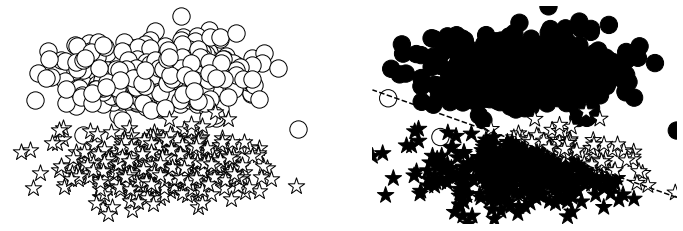

In [46]:
import import_ipynb
from perceptron import visualize_results
import matplotlib.pyplot as plt

left_x = []
right_x = []
left_colors = []
right_colors =  []

# Construct a stack of values and colors
for x_i, y_true_i in zip(x_data, y_truth):
    color = 'black'

    if y_true_i == 0:
        left_x.append(x_i)
        left_colors.append(color)

    else:
        right_x.append(x_i)
        right_colors.append(color)

left_x = np.stack(left_x)
right_x = np.stack(right_x)

_, axes = plt.subplots(1,2,figsize=(12,4))

perceptron = Perceptron(input_dim=input_dim)
axes[0].scatter(left_x[:, 0], left_x[:, 1], facecolor='white',edgecolor='black', marker='o', s=300)
axes[0].scatter(right_x[:, 0], right_x[:, 1], facecolor='white', edgecolor='black', marker='*', s=300)
axes[0].axis('off')
visualize_results(perceptron, x_data, y_truth, epoch=None, levels=[0.5], ax=axes[1])
axes[1].axis('off')